In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:158: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:42: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:46: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:49: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

In [5]:
sector_rtns={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_rtns[sect]=np.log(cleansed[d_map[sect]].resample(rule='m',how='last')).diff().dropna(how='all')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.


# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


# Amihud (2002) Annual portfolio sorts

In [6]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

tsmom_model.py:273: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
tsmom_model.py:273: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


# Annual portfolio sorts

In [7]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,2)

tsmom_model.py:238: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
tsmom_model.py:239: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)


In [8]:
sector_portfolio_sorts_mon={}
for s in sector_zscores.keys():
    sector_portfolio_sorts_mon[s]=quantile_portfolios_monthly(sector_zscores[s],cleansed,2)
sector_portfolio_sorts_mon['All']=quantile_portfolios_annual(data,cleansed,2)

tsmom_model.py:251: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns_monthly(rank_data.resample(rule='m',how='median'),mon,number_of_buckets,i)
/Users/mrefermat/anaconda/lib/python2.7/site-packages/pandas/core/internals.py:3871: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  block = self.blocks[self._blknos[i]]
tsmom_model.py:258: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[next_mon].mean(axis=1)


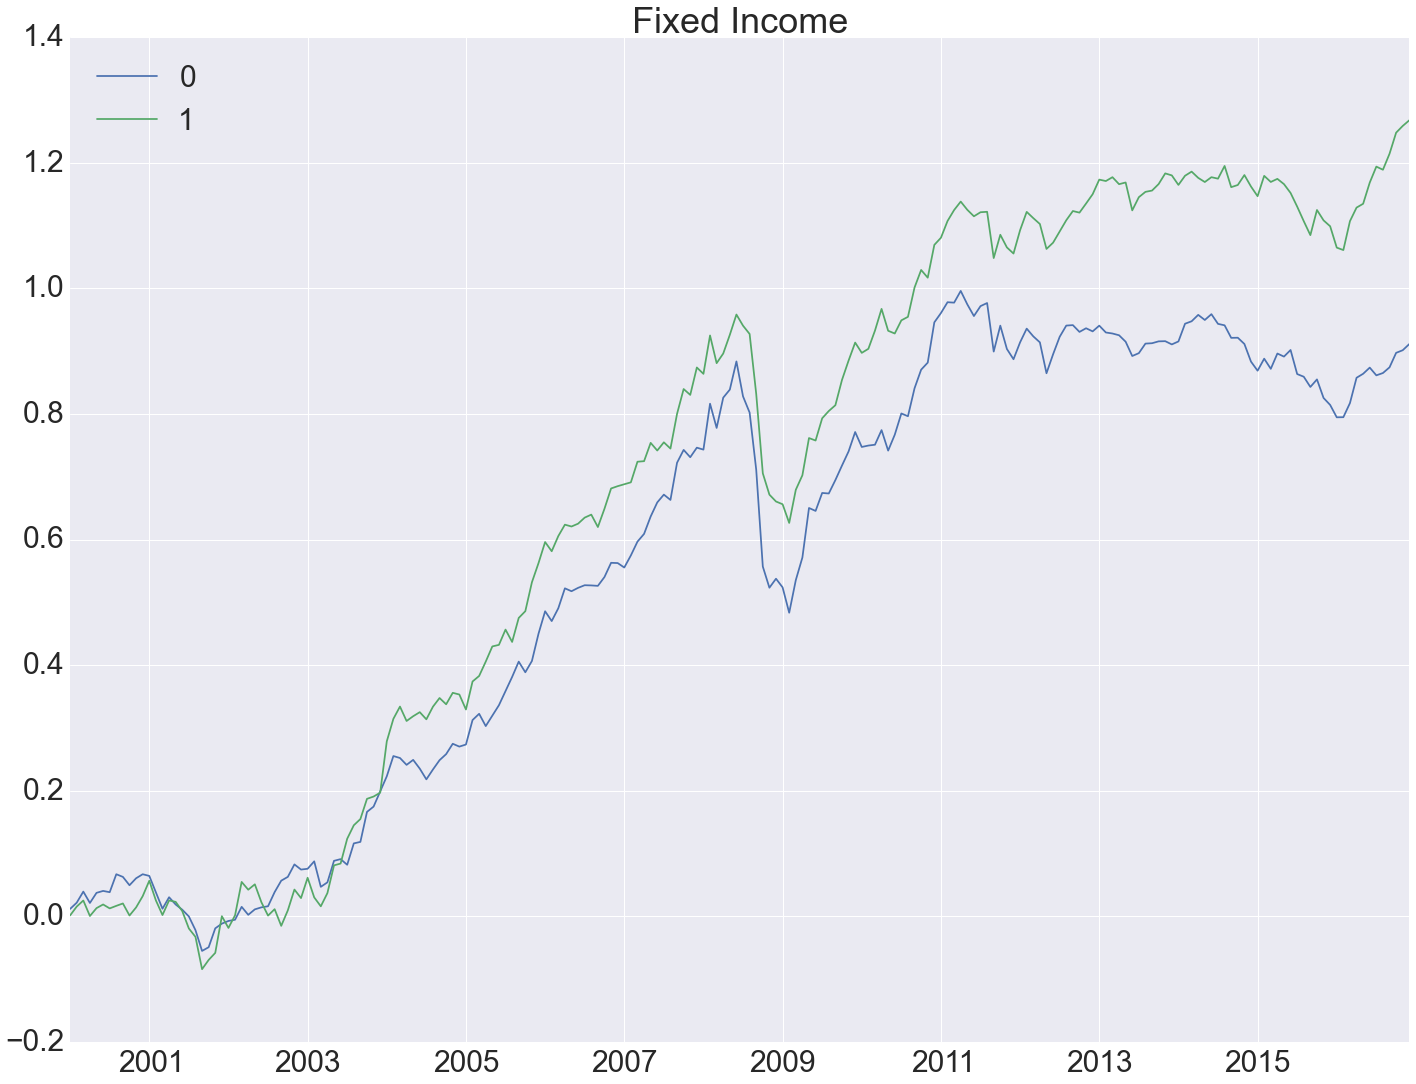

In [9]:
sector_portfolio_sorts_mon['All'].cumsum().plot(title=s)

In [10]:
for s in sector_portfolio_sorts_mon.keys():
    sector_portfolio_sorts_mon[s].to_pickle('data/'+s+'_monthly.pickle')


In [11]:
sector_portfolio_sorts_mon.keys()

['Agriculturals',
 'All',
 'Currencies',
 'Energies',
 'Equities',
 'Metals',
 'Fixed Income']

In [12]:
data=read_monthly()

In [13]:
data.keys()

['Agriculturals',
 'All',
 'Currencies',
 'Energies',
 'Equities',
 'Metals',
 'Fixed Income']

for sec in sector_:
    print(sec)
    print(portfolio_sort_table(sector_portfolio_sorts[sec],sector_rtns[sec]).to_latex())

In [14]:
FHT=calculate_FHT(cleansed)
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(FHT)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

tsmom_model.py:283: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
tsmom_model.py:284: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
tsmom_model.py:285: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:285: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')


In [15]:
sector_portfolio_sorts_FHT_mon={}
for s in sector_zscores.keys():
    sector_portfolio_sorts_FHT_mon[s]=quantile_portfolios_monthly(sector_zscores[s],cleansed,2)
sector_portfolio_sorts_FHT_mon['All']=quantile_portfolios_monthly(data,cleansed,2)

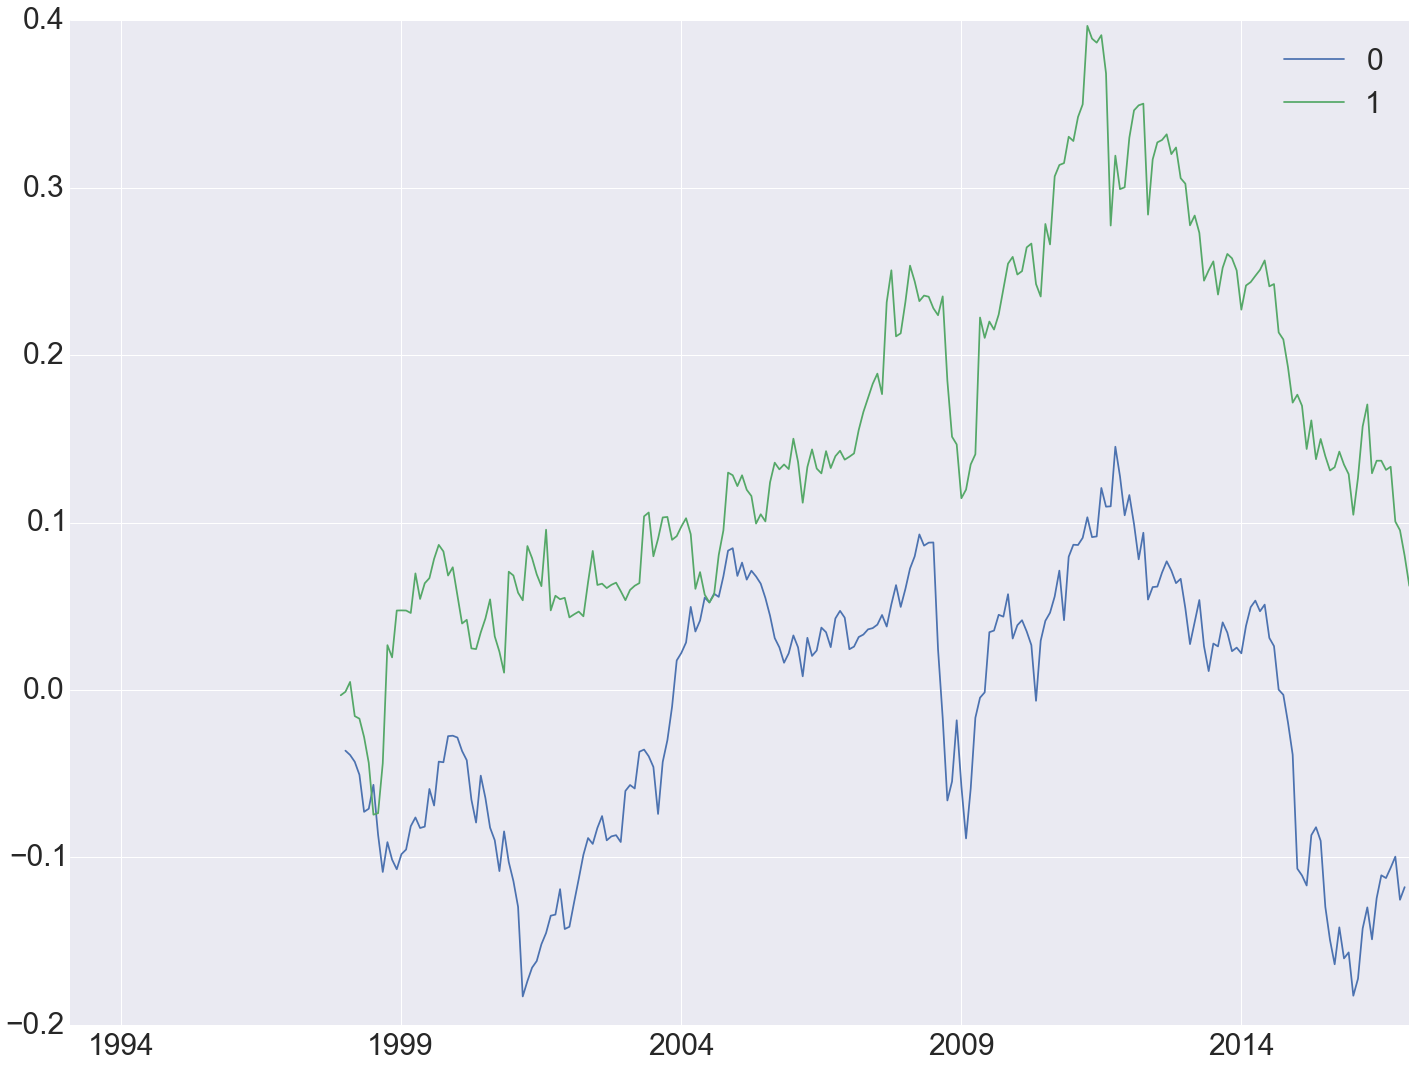

In [21]:
sector_portfolio_sorts_FHT_mon['Currencies'].cumsum().plot()

In [22]:
for s in sector_portfolio_sorts_FHT_mon.keys():
    sector_portfolio_sorts_FHT_mon[s].to_pickle('data/'+s+'_monthly_FHT.pickle')

In [23]:

sector_portfolio_sorts_FHT_mon.keys()

['Agriculturals',
 'All',
 'Currencies',
 'Energies',
 'Equities',
 'Metals',
 'Fixed Income']

In [26]:
read_monthly(amihud=False)['Currencies'].dropna()

,0,1
1998-01-31,-0.036235,0.002079
1998-02-28,-0.002583,0.005890
1998-03-31,-0.004067,-0.020434
1998-04-30,-0.007770,-0.001524
1998-05-31,-0.022125,-0.010998
1998-06-30,0.001864,-0.015441
1998-07-31,0.014286,-0.030912
1998-08-31,-0.029867,0.000894
1998-09-30,-0.022206,0.029801
1998-10-31,0.017811,0.070575


In [20]:
sector_portfolio_sorts_FHT_mon['All']


,0,1
1992-02-29,-0.017646,-0.008464
1992-03-31,-0.017975,0.007860
1992-04-30,0.008664,-0.023294
1992-05-31,0.011295,0.020023
1992-06-30,-0.000378,-0.014568
1992-07-31,-0.007734,-0.010193
1992-08-31,-0.002087,-0.005754
1992-09-30,0.014756,-0.002328
1992-10-31,-0.016338,0.012824
1992-11-30,0.014728,0.003868
